In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import random
import soundfile as sf

from tensorflow import keras
from keras import layers

import seaborn as sns

In [2]:
processed_data_dir = './processed_dataset/'
data_in_use_dir = './data_in_use/'

sample_rate = 16000

In [3]:
def get_spectrogram(waveform):
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

def plot_spectrogram(spectrogram, ax):
    log_spec = np.log(spectrogram.T)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

In [4]:
commands = np.array(tf.io.gfile.listdir(str(processed_data_dir)))
print('Commands:', commands)

# create folder in data_in_use for each command
try:
    for command in commands:
        os.mkdir(data_in_use_dir +"/"+command)   
except:
    print('Folder already exist')

Commands: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [13]:
# Define the split percentages
train_percent = 0.8
val_percent = 0.1
test_percent = 0.1

try:
    # Create directories for train, validation, and test
    train_dir = os.path.join(data_in_use_dir, 'train')
    val_dir = os.path.join(data_in_use_dir, 'val')
    test_dir = os.path.join(data_in_use_dir, 'test')

    os.makedirs(train_dir, exist_ok=False)
    os.makedirs(val_dir, exist_ok=False)
    os.makedirs(test_dir, exist_ok=False)

    for command in commands:
        command_path = os.path.join(processed_data_dir, command)
        filenames = os.listdir(command_path)
        random.shuffle(filenames)  # Shuffle the files

        # Calculate split indices
        num_files = len(filenames)
        num_train = int(num_files * train_percent)
        num_val = int(num_files * val_percent)

        # Split the files into train, val, and test
        train_files = filenames[:num_train]
        val_files = filenames[num_train:num_train + num_val]
        test_files = filenames[num_train + num_val:]

        # Move the files to their respective directories
        for filename in train_files:
            src = os.path.join(command_path, filename)
            dst = os.path.join(train_dir, command, filename) 
            os.makedirs(os.path.dirname(dst), exist_ok=True)
            shutil.copy(src, dst)

        for filename in val_files:
            src = os.path.join(command_path, filename)
            dst = os.path.join(val_dir, command, filename)
            os.makedirs(os.path.dirname(dst), exist_ok=True)
            shutil.copy(src, dst)

        for filename in test_files:
            src = os.path.join(command_path, filename)
            dst = os.path.join(test_dir, command, filename)
            os.makedirs(os.path.dirname(dst), exist_ok=True)
            shutil.copy(src, dst)

    print("Data split into train, validation, and test sets.")
except:
    print('Data already split')

Data already split


In [44]:
batch_size = 64

train_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_in_use_dir + "train",
    batch_size=batch_size,
    validation_split=0.2,  # Adjust the validation split as needed
    seed=0,
    output_sequence_length=16000,  # Set the desired sequence length
    subset='training'  # Use 'validation' for the validation dataset
)

# Get the class names from the training dataset
label_names = np.array(train_ds)
print("Label names:", train_ds.class_names)

Found 7738 files belonging to 8 classes.
Using 6191 files for training.
Label names: ['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes']


In [45]:
batch_size = 64

val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_in_use_dir + "val",
    batch_size=batch_size,
    validation_split=0.2,  # Adjust the validation split as needed
    seed=0,
    output_sequence_length=16000,  # Set the desired sequence length
    subset='validation'  # Use 'validation' for the validation dataset
)

label_names = np.array(val_ds)
print("Label names:", val_ds)

Found 1676 files belonging to 8 classes.
Using 335 files for validation.
Label names: <_BatchDataset element_spec=(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [16]:
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

train_ds = train_ds.map(squeeze)
val_ds = val_ds.map(squeeze)


In [42]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

Waveform shape: tf.Tensor([13654], shape=(1,), dtype=int32)
Spectrogram shape: tf.Tensor([105 129   1], shape=(3,), dtype=int32)
Waveform shape: tf.Tensor([13654], shape=(1,), dtype=int32)
Spectrogram shape: tf.Tensor([105 129   1], shape=(3,), dtype=int32)


Text(0.5, 1.0, 'Spectrogram')

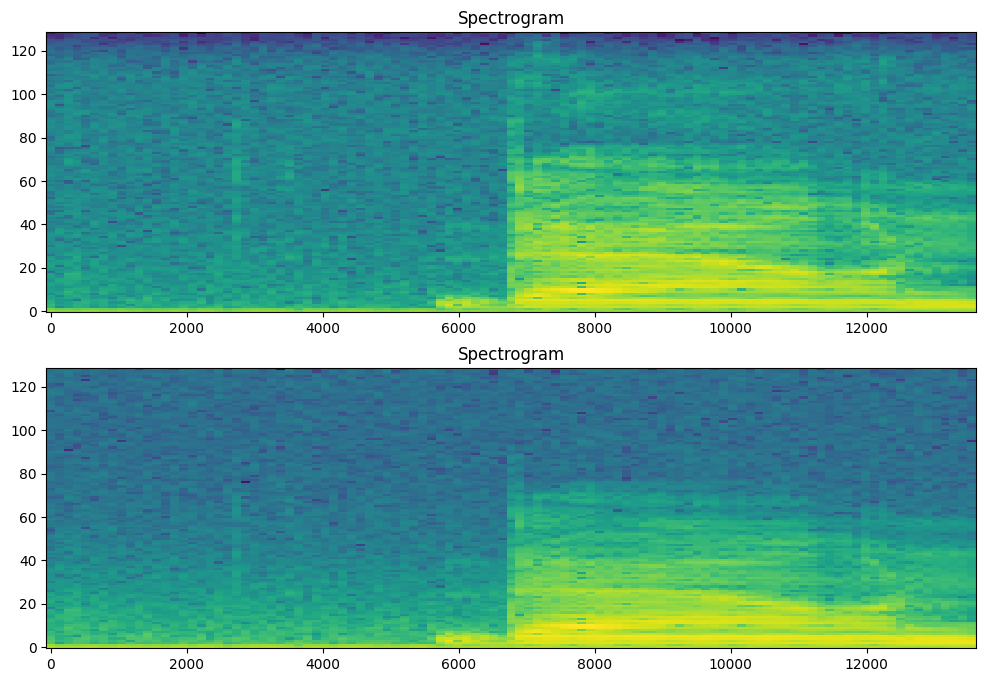

In [5]:
audio_path_1 = "./dataset/mini_speech_commands/down/0a9f9af7_nohash_0.wav"
audio_path_2 = "./processed_dataset/down/0a9f9af7_nohash_0.wav"

num_audio1, sample_rate = sf.read(audio_path_1)
num_audio2, sample_rate = sf.read(audio_path_2)

spectrogram1 = get_spectrogram(num_audio1)
waveform1 = tf.squeeze(num_audio1)
waveform_shape1 = tf.shape(waveform1)
spectrogram_shape1 = tf.shape(spectrogram1)

waveform2 = tf.squeeze(num_audio2)
spectrogram2 = get_spectrogram(waveform2)
waveform_shape2 = tf.shape(waveform2)
spectrogram_shape2 = tf.shape(spectrogram2)

print("Waveform shape:", waveform_shape1)
print("Spectrogram shape:", spectrogram_shape1)

print("Waveform shape:", waveform_shape2)
print("Spectrogram shape:", spectrogram_shape2)

fig, axes = plt.subplots(2, figsize=(12, 8))
ax = axes[0]
plot_spectrogram(np.squeeze(spectrogram1.numpy()), ax)
ax.set_title('Spectrogram')

ax = axes[1]
plot_spectrogram(np.squeeze(spectrogram2.numpy()), ax)
ax.set_title('Spectrogram')



In [33]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [43]:
desired_input_shape = (13654, 1)

train_spectrogram_ds = train_ds.map(lambda spec, label: (tf.reshape(spec, desired_input_shape), label))
val_spectrogram_ds = val_ds.map(lambda spec, label: (tf.reshape(spec, desired_input_shape), label))
test_spectrogram_ds = test_ds.map(lambda spec, label: (tf.reshape(spec, desired_input_shape), label))

ValueError: in user code:

    File "C:\Users\ACER\AppData\Local\Temp\ipykernel_15432\2493009235.py", line 3, in None  *
        lambda spec, label: (tf.reshape(spec, desired_input_shape), label)

    ValueError: Dimension size must be evenly divisible by 16000 but is 13654 for '{{node Reshape}} = Reshape[T=DT_FLOAT, Tshape=DT_INT32](args_0, Reshape/shape)' with input shapes: [?,16000], [2] and with input tensors computed as partial shapes: input[1] = [13654,1].


In [41]:
audio_path_1 = "./dataset/mini_speech_commands/down/0a9f9af7_nohash_0.wav"
spectrogram1 = get_spectrogram(num_audio1)
waveform1 = tf.squeeze(num_audio1)

input_shape = spectrogram1.shape[1:]
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = layers.Normalization()
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = keras.Sequential([
    layers.Input(shape=(13654, 1)),
    layers.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()


Input shape: (129, 1)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_6 (Resizing)       (32, 32, 1)               0         
                                                                 
 normalization_11 (Normaliz  (1, 32, 32, 1)            3         
 ation)                                                          
                                                                 
 conv2d_12 (Conv2D)          (1, 30, 30, 32)           320       
                                                                 
 conv2d_13 (Conv2D)          (1, 28, 28, 64)           18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (1, 14, 14, 64)           0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (1,

In [38]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)